# Import the dataset from kaggle

In [1]:
!pip install kagglehub
import kagglehub

path = kagglehub.dataset_download("geraldooizx/g-coffee-shop-transaction-202307-to-202506")

print("Dataset downloaded successfully!")
print("Path to dataset files:", path)

Dataset downloaded successfully!
Path to dataset files: C:\Users\Yang\.cache\kagglehub\datasets\geraldooizx\g-coffee-shop-transaction-202307-to-202506\versions\1


# Check the dataset structure

In [2]:
import os

def list_dataset_files(base_path):
    for root, dirs, files in os.walk(base_path):
        level = root.replace(base_path, "").count(os.sep)
        indent = " " * 4 * (level)
        print(f"{indent} {os.path.basename(root)}/")
        sub_indent = " " * 4 * (level + 1)
        for f in files:
            print(f"{sub_indent} {f}")

list_dataset_files(path)

 1/
     menu_items/
         menu_items.csv
     payment_methods/
         payment_methods.csv
     stores/
         stores.csv
     transactions/
         transactions_202307.csv
         transactions_202308.csv
         transactions_202309.csv
         transactions_202310.csv
         transactions_202311.csv
         transactions_202312.csv
         transactions_202401.csv
         transactions_202402.csv
         transactions_202403.csv
         transactions_202404.csv
         transactions_202405.csv
         transactions_202406.csv
         transactions_202407.csv
         transactions_202408.csv
         transactions_202409.csv
         transactions_202410.csv
         transactions_202411.csv
         transactions_202412.csv
         transactions_202501.csv
         transactions_202502.csv
         transactions_202503.csv
         transactions_202504.csv
         transactions_202505.csv
         transactions_202506.csv
     transaction_items/
         transaction_items_202307.cs

# Create SparkSession

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CoffeeShopDataProcessing") \
    .master("local[1]") \
    .getOrCreate()

print("SparkSession created successfully")

SparkSession created successfully


# Load All Data


In [4]:
menu_items_folder = os.path.join(path, "menu_items")
df_menu_items = spark.read.csv(os.path.join(menu_items_folder, "menu_items.csv"), header=True, inferSchema=True)

print("Menu Items DataFrame Schema:")
df_menu_items.printSchema()
print("\nFirst 5 rows:")
df_menu_items.show(5)

Menu Items DataFrame Schema:
root
 |-- item_id: integer (nullable = true)
 |-- item_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: double (nullable = true)
 |-- is_seasonal: boolean (nullable = true)
 |-- available_from: string (nullable = true)
 |-- available_to: string (nullable = true)


First 5 rows:
+-------+----------+--------+-----+-----------+--------------+------------+
|item_id| item_name|category|price|is_seasonal|available_from|available_to|
+-------+----------+--------+-----+-----------+--------------+------------+
|      1|  Espresso|  coffee|  6.0|      false|          null|        null|
|      2| Americano|  coffee|  7.0|      false|          null|        null|
|      3|     Latte|  coffee|  8.0|      false|          null|        null|
|      4|Cappuccino|  coffee|  8.0|      false|          null|        null|
|      5|Flat White|  coffee|  9.0|      false|          null|        null|
+-------+----------+--------+-----+-----------+---

In [5]:
payment_methods_folder = os.path.join(path, "payment_methods")
df_payment_methods = spark.read.csv(os.path.join(payment_methods_folder, "payment_methods.csv"), header=True, inferSchema=True)

print("Payment Methods DataFrame Schema:")
df_payment_methods.printSchema()
print("\nFirst 5 rows:")
df_payment_methods.show(5)

Payment Methods DataFrame Schema:
root
 |-- method_id: integer (nullable = true)
 |-- method_name: string (nullable = true)
 |-- category: string (nullable = true)


First 5 rows:
+---------+-----------+--------+
|method_id|method_name|category|
+---------+-----------+--------+
|        1|       cash|    cash|
|        2|credit_card|    card|
|        3| debit_card|    card|
|        4|        tng| ewallet|
|        5|    grabpay| ewallet|
+---------+-----------+--------+



In [6]:
stores_folder = os.path.join(path, "stores")
df_stores = spark.read.csv(os.path.join(stores_folder, "stores.csv"), header=True, inferSchema=True)

print("Stores DataFrame Schema:")
df_stores.printSchema()
print("\nFirst 5 rows:")
df_stores.show(5)

Stores DataFrame Schema:
root
 |-- store_id: integer (nullable = true)
 |-- store_name: string (nullable = true)
 |-- street: string (nullable = true)
 |-- postal_code: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)


First 5 rows:
+--------+--------------------+--------------------+-----------+-----------------+--------------------+--------+----------+
|store_id|          store_name|              street|postal_code|             city|               state|latitude| longitude|
+--------+--------------------+--------------------+-----------+-----------------+--------------------+--------+----------+
|       1|  G Coffee @ USJ 89q|Jalan Dewan Bahas...|      50998|          USJ 89q|        Kuala Lumpur|3.117134|101.615027|
|       2|G Coffee @ Kondom...|          Jln Yew 6X|      63826|Kondominium Putra|Selangor Darul Ehsan|2.959571| 101.51772|
|       3|  G C

In [7]:
# Transactions folder
transactions_folder = os.path.join(path, "transactions")
transactions_files_full = [os.path.join(transactions_folder, f) 
                           for f in os.listdir(transactions_folder) if f.endswith(".csv")]

# Load all CSVs into a single DataFrame
df_transactions = spark.read.option("header", True).option("inferSchema", True).csv(transactions_files_full)

print("Transactions DataFrame Schema:")
df_transactions.printSchema()
print("\nFirst 5 rows of Transactions:")
df_transactions.show(5)

Transactions DataFrame Schema:
root
 |-- transaction_id: string (nullable = true)
 |-- store_id: integer (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- voucher_id: double (nullable = true)
 |-- user_id: double (nullable = true)
 |-- original_amount: double (nullable = true)
 |-- discount_applied: double (nullable = true)
 |-- final_amount: double (nullable = true)
 |-- created_at: timestamp (nullable = true)


First 5 rows of Transactions:
+--------------------+--------+-----------------+----------+---------+---------------+----------------+------------+-------------------+
|      transaction_id|store_id|payment_method_id|voucher_id|  user_id|original_amount|discount_applied|final_amount|         created_at|
+--------------------+--------+-----------------+----------+---------+---------------+----------------+------------+-------------------+
|e75220ac-6b77-484...|       1|                4|      16.0|  92761.0|            9.0|             4.5|         4.5|202

In [8]:
# Transaction Items folder
transaction_items_folder = os.path.join(path, "transaction_items")
transaction_items_files_full = [os.path.join(transaction_items_folder, f) 
                                for f in os.listdir(transaction_items_folder) if f.endswith(".csv")]

# Load all CSVs into a single DataFrame
df_transaction_items = spark.read.option("header", True).option("inferSchema", True).csv(transaction_items_files_full)

print("Transaction Items DataFrame Schema:")
df_transaction_items.printSchema()
print("\nFirst 5 rows of Transaction Items:")
df_transaction_items.show(5)

Transaction Items DataFrame Schema:
root
 |-- transaction_id: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- subtotal: double (nullable = true)
 |-- created_at: timestamp (nullable = true)


First 5 rows of Transaction Items:
+--------------------+-------+--------+----------+--------+-------------------+
|      transaction_id|item_id|quantity|unit_price|subtotal|         created_at|
+--------------------+-------+--------+----------+--------+-------------------+
|2c3b6119-5833-44c...|      3|       1|       8.0|     8.0|2024-08-01 07:00:15|
|3614abbc-000c-467...|      8|       3|      10.0|    30.0|2024-08-01 14:19:04|
|3614abbc-000c-467...|      3|       1|       8.0|     8.0|2024-08-01 14:19:04|
|909aa18e-b24e-493...|      3|       2|       8.0|    16.0|2024-08-01 14:19:05|
|7145a8ec-d788-4a0...|      2|       2|       7.0|    14.0|2024-08-01 14:19:06|
+--------------------+------

In [9]:
# Users folder
users_folder = os.path.join(path, "users")
users_files_full = [os.path.join(users_folder, f) 
                    for f in os.listdir(users_folder) if f.endswith(".csv")]

# Load all CSVs into a single DataFrame
df_users = spark.read.option("header", True).option("inferSchema", True).csv(users_files_full)

print("Users DataFrame Schema:")
df_users.printSchema()
print("\nFirst 5 rows of Users:")
df_users.show(5)

Users DataFrame Schema:
root
 |-- user_id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthdate: timestamp (nullable = true)
 |-- registered_at: timestamp (nullable = true)


First 5 rows of Users:
+-------+------+-------------------+-------------------+
|user_id|gender|          birthdate|      registered_at|
+-------+------+-------------------+-------------------+
|1833761|female|1998-10-04 00:00:00|2025-05-01 08:17:21|
|1833762|female|1986-12-07 00:00:00|2025-05-01 08:17:26|
|1833763|female|2009-02-15 00:00:00|2025-05-01 08:17:39|
|1833764|female|1967-06-02 00:00:00|2025-05-01 08:18:04|
|1833765|  male|1966-04-20 00:00:00|2025-05-01 08:18:07|
+-------+------+-------------------+-------------------+
only showing top 5 rows



In [10]:
vouchers_folder = os.path.join(path, "vouchers")
df_vouchers = spark.read.csv(os.path.join(vouchers_folder, "vouchers.csv"), header=True, inferSchema=True)

print("Vouchers DataFrame Schema:")
df_vouchers.printSchema()
print("\nFirst 5 rows:")
df_vouchers.show(5)

Vouchers DataFrame Schema:
root
 |-- voucher_id: integer (nullable = true)
 |-- voucher_code: string (nullable = true)
 |-- discount_type: string (nullable = true)
 |-- discount_value: double (nullable = true)
 |-- valid_from: timestamp (nullable = true)
 |-- valid_to: timestamp (nullable = true)


First 5 rows:
+----------+------------+-------------+--------------+-------------------+-------------------+
|voucher_id|voucher_code|discount_type|discount_value|         valid_from|           valid_to|
+----------+------------+-------------+--------------+-------------------+-------------------+
|         1|     SALES77|   percentage|           7.0|2023-07-07 00:00:00|2023-07-09 00:00:00|
|         2|     SALES88|   percentage|           8.0|2023-08-08 00:00:00|2023-08-10 00:00:00|
|         3|     SALES99|   percentage|           9.0|2023-09-09 00:00:00|2023-09-11 00:00:00|
|         4|     SALES10|   percentage|          10.0|2023-10-10 00:00:00|2023-10-12 00:00:00|
|         5|     SALE

# Check the dataframes size

In [11]:
# Create a dictionary and store the corresponding name of each DataFrame
dataframes = {
    "Transactions": df_transactions,
    "Transaction Items": df_transaction_items,
    "Users": df_users,
    "Menu Items": df_menu_items,
    "Stores": df_stores,
    "Vouchers": df_vouchers,
    "Payment Methods": df_payment_methods
}

# Loop through each DataFrame and print the number of rows
for name, df in dataframes.items():
    print(f"{name} row count: {df.count()}")

Transactions row count: 14623691
Transaction Items row count: 29246323
Users row count: 2196257
Menu Items row count: 8
Stores row count: 10
Vouchers row count: 16
Payment Methods row count: 5


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import sum, month, year

# Convert to a Pandas auxiliary table
df_stores_pd = df_stores.toPandas()
df_payment_methods_pd = df_payment_methods.toPandas()
df_menu_items_pd = df_menu_items.toPandas()

## Monthly Sales Trend

In this analysis, we calculate the **total sales per month** based on the transaction data.  
This helps us understand revenue trends over time and identify peak or low-performing months.

Steps:
- Extract `year` and `month` from the `created_at` column.
- Aggregate total sales (`final_amount`) per year-month.
- Visualize using a lin chart.


C:\Users\Yang\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Yang\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


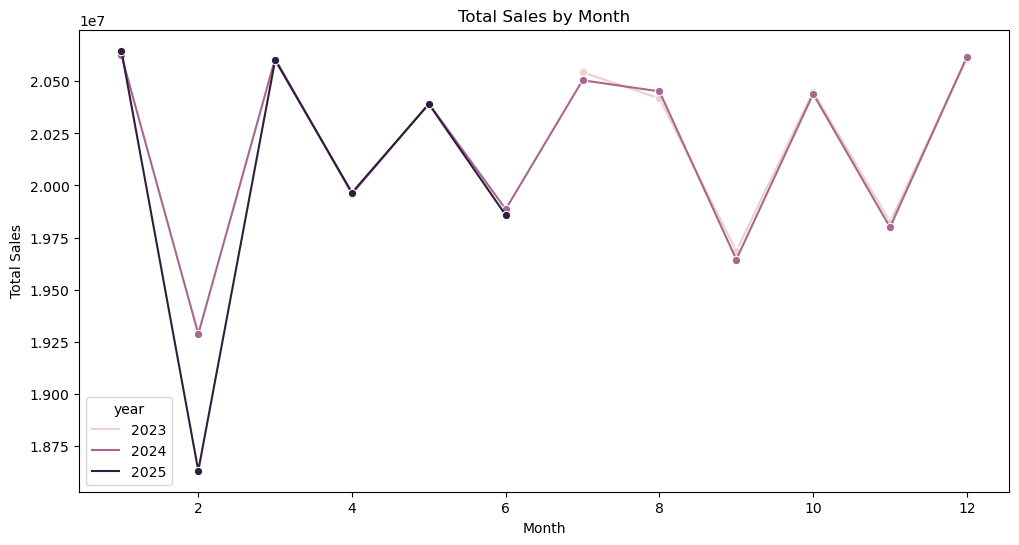

In [13]:
# Spark Analytics
sales_by_month = df_transactions.groupBy(
    year("created_at").alias("year"),
    month("created_at").alias("month")
).agg(sum("final_amount").alias("total_sales")).orderBy("year", "month")

# Convert to Pandas
sales_by_month_pd = sales_by_month.toPandas()

# Visualization
plt.figure(figsize=(12,6))
sns.lineplot(data=sales_by_month_pd, x="month", y="total_sales", hue="year", marker="o")
plt.title("Total Sales by Month")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.show()

## Total Sales by Store

This analysis shows which store contributes the most to overall sales.  
It helps identify the **top-performing stores** and those with relatively low sales.

Steps:
- Group transactions by `store_id`.
- Aggregate sales (`final_amount`) per store.
- Join with store names for readability.
- Visualize using a br chart.


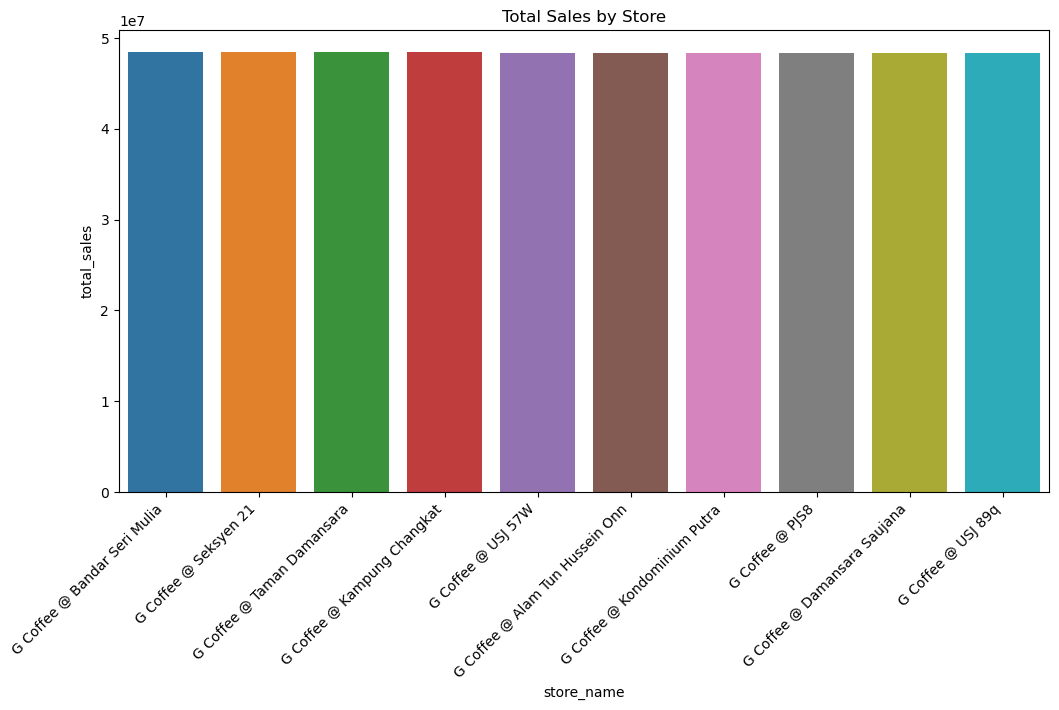

In [14]:
# Spark Analytics
sales_by_store = df_transactions.groupBy("store_id") \
    .agg(sum("final_amount").alias("total_sales")) \
    .orderBy("total_sales", ascending=False)

# Convert to Pandas and merge store names
sales_by_store_pd = sales_by_store.toPandas().merge(
    df_stores_pd[["store_id", "store_name"]], on="store_id", how="left"
)

# Visualization
plt.figure(figsize=(12,6))
sns.barplot(data=sales_by_store_pd, x="store_name", y="total_sales")
plt.xticks(rotation=45, ha="right")
plt.title("Total Sales by Store")
plt.show()

## Top 5 Best-Selling Menu Items

We analyze which menu items are sold the most.  
This provides insights into **customer preferences** and helps guide **inventory planning**.

Steps:
- Group by `menu_item_id`.
- Count total quantity sold.
- Join with menu item names for clarity.
- Select **top 5 items** and visualize.

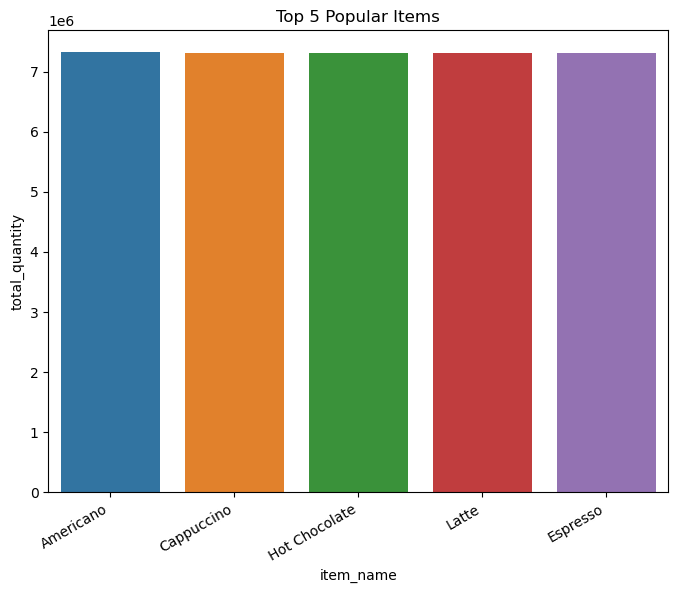

In [15]:
# Spark Analytics
popular_items = df_transaction_items.groupBy("item_id") \
    .agg(sum("quantity").alias("total_quantity")) \
    .orderBy("total_quantity", ascending=False)

# Convert to Pandas and merge product names
popular_items_pd = popular_items.toPandas().merge(
    df_menu_items_pd[["item_id", "item_name"]], on="item_id", how="left"
)

# Take the top 5
top_items = popular_items_pd.head(5)

# Visualization
plt.figure(figsize=(8,6))
sns.barplot(data=top_items, x="item_name", y="total_quantity")
plt.xticks(rotation=30, ha="right")
plt.title("Top 5 Popular Items")
plt.show()


## User Age Group Analysis

In this step, we calculate the **age of each user** from their birthdate by subtracting the birth year from the current year.  
Next, we categorize users into **age groups**:  

- `<20`  
- `20-29`  
- `30-39`  
- `40+`  

Finally, we count the number of users in each age group and convert the result to Pandas for visualization.  

This analysis helps us understand the **age distribution of customers**, which can provide insights for targeted marketing or customer segmentation.

In [16]:
from pyspark.sql.functions import current_date, year, col, when

# Calculate age
users_age = df_users.withColumn("user_age", year(current_date()) - year(col("birthdate")))

# Grouping
users_age_group = users_age.withColumn(
    "age_group",
    when(col("user_age") < 20, "<20")
    .when((col("user_age") >= 20) & (col("user_age") <= 29), "20-29")
    .when((col("user_age") >= 30) & (col("user_age") <= 39), "30-39")
    .otherwise("40+")
)

age_group_pd = users_age_group.groupBy("age_group").count().toPandas()

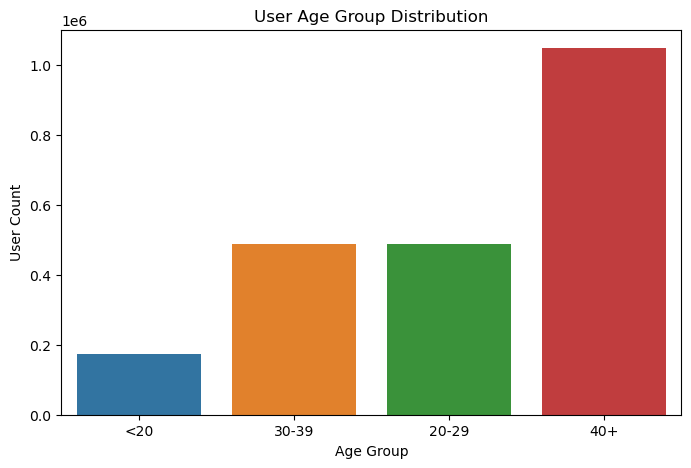

In [17]:
# User Age Group Distribution
plt.figure(figsize=(8,5))
sns.barplot(data=age_group_pd, x="age_group", y="count")
plt.title("User Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("User Count")
plt.show()